In [41]:
# Brain MRI tumor segmentation with Otsu and Sauvola
# Simple notebook for my course project.

print("Brain MRI tumor segmentation notebook")

Brain MRI tumor segmentation notebook


In [42]:
# Basic imports and paths for the project

import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, filters
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.morphology import remove_small_objects, remove_small_holes, opening, disk

# Make plots appear inline and set a consistent style
plt.style.use("seaborn-v0_8")

# Define base paths (adapt to your environment if you move the notebook)
PROJECT_ROOT = Path(r"c:\Users\amitk\Desktop\DL-medical-image\Project-1")
DATA_ROOT = PROJECT_ROOT / "Brain-tumor"

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)

# Sanity check: how many patient folders are there?
patient_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print(f"Found {len(patient_dirs)} patient folders (example: {patient_dirs[0].name})")

Project root: c:\Users\amitk\Desktop\DL-medical-image\Project-1
Data root: c:\Users\amitk\Desktop\DL-medical-image\Project-1\Brain-tumor
Found 110 patient folders (example: TCGA_CS_4941_19960909)


In [43]:
"""Utility functions for loading MRI slices and masks.

- Each patient has a folder, e.g. `TCGA_CS_4941_19960909/`.
- Inside each folder, each slice has a pair of files:
  - `<patient>_<slice_index>.tif`        → original MRI slice
  - `<patient>_<slice_index>_mask.tif`   → corresponding binary tumor mask

The functions below:
- `list_slice_pairs(patient_dir)`: returns sorted (image_path, mask_path) pairs.
- `load_slice_and_mask(img_path, mask_path)`: reads the image and mask, converts
  to grayscale and normalizes intensities to [0, 1].
"""

from typing import List, Tuple


def list_slice_pairs(patient_dir: Path) -> List[Tuple[Path, Path]]:
    """Return (image, mask) path pairs for a given patient folder.

    We match files by the pattern `*_mask.tif` for masks and the same prefix
    without `_mask` for the corresponding MRI slice.
    """
    patient_dir = Path(patient_dir)

    mask_paths = sorted(patient_dir.glob("*_mask.tif"))
    pairs = []
    for mpath in mask_paths:
        img_path = patient_dir / mpath.name.replace("_mask", "")
        if img_path.exists():
            pairs.append((img_path, mpath))
    return pairs


def load_slice_and_mask(img_path: Path, mask_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """Load an MRI slice and its mask as 2D numpy arrays in [0, 1]."""
    # Read image; some images might be RGB; convert to grayscale
    img = io.imread(str(img_path))
    if img.ndim == 3:
        img = rgb2gray(img)

    # Normalize intensities for more stable thresholding
    img = rescale_intensity(img, in_range="image", out_range=(0.0, 1.0))

    # Read mask; usually already binary, but we map it to {0, 1}
    mask = io.imread(str(mask_path))
    if mask.ndim == 3:
        mask = rgb2gray(mask)
    mask = (mask > 0).astype(np.uint8)

    return img, mask


# Quick test on the first patient to make sure paths are correct
example_patient = patient_dirs[0]
example_pairs = list_slice_pairs(example_patient)
print(f"Example patient: {example_patient.name}, #slices with masks: {len(example_pairs)}")
print("First pair:", example_pairs[0])

Example patient: TCGA_CS_4941_19960909, #slices with masks: 23
First pair: (WindowsPath('c:/Users/amitk/Desktop/DL-medical-image/Project-1/Brain-tumor/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'), WindowsPath('c:/Users/amitk/Desktop/DL-medical-image/Project-1/Brain-tumor/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'))


In [44]:
# Small image preprocessing and mask-cleaning helpers

from skimage import exposure


def preprocess_image(img: np.ndarray) -> np.ndarray:
    """Enhance local contrast of a [0, 1] grayscale MRI image.

    Using CLAHE (adaptive histogram equalization) with a small
    `clip_limit` to avoid over-amplifying noise.
    """
    img = np.clip(img, 0.0, 1.0)
    img_eq = exposure.equalize_adapthist(img, clip_limit=0.01)
    return img_eq


def clean_mask(mask: np.ndarray,
               max_obj_size: int = 50,
               max_hole_size: int = 50) -> np.ndarray:
    """Simple clean‑up on the binary mask (remove tiny bits, fill holes)."""
    mask_bool = mask.astype(bool)
    # New scikit-image versions expect `max_size` instead of `min_size` / `area_threshold`.
    mask_bool = remove_small_objects(mask_bool, max_size=max_obj_size)
    mask_bool = remove_small_holes(mask_bool, max_size=max_hole_size)
    mask_bool = opening(mask_bool, footprint=disk(2))
    return mask_bool.astype(np.uint8)

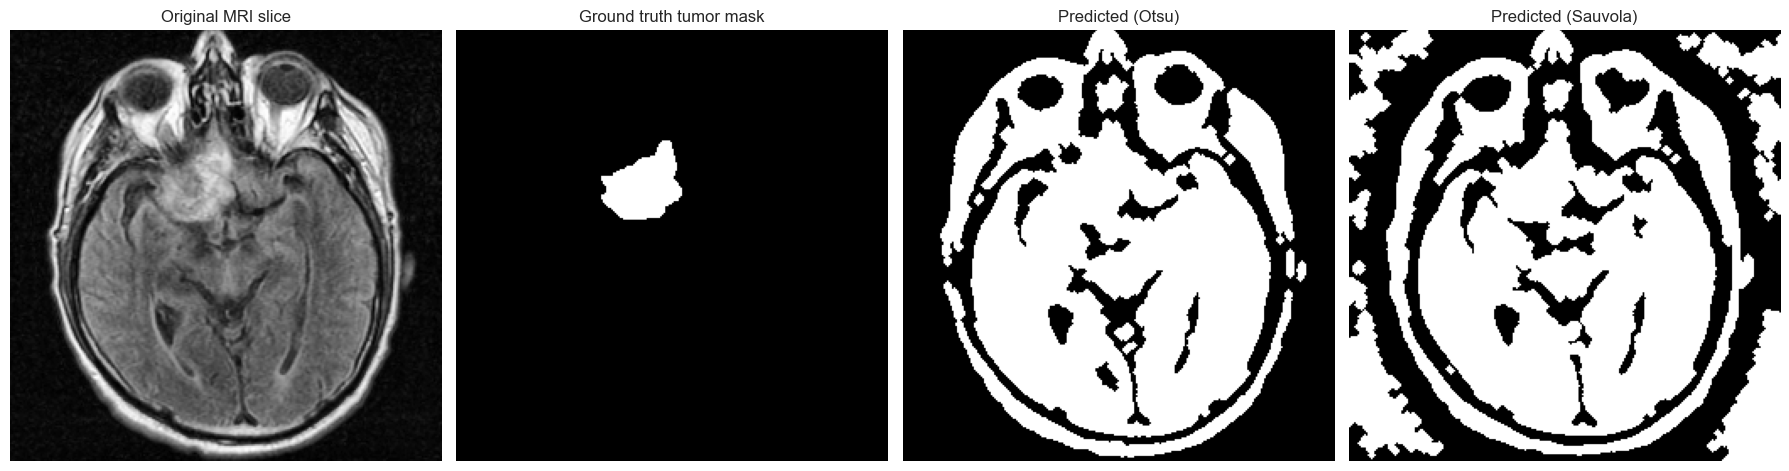

In [45]:
# Otsu and Sauvola thresholding for tumor segmentation

from skimage.filters import threshold_otsu, threshold_sauvola


def segment_otsu(img: np.ndarray, foreground: str = "bright") -> np.ndarray:
    """Segment tumor using a single global Otsu threshold.

    Parameters
    img : np.ndarray
        Preprocessed grayscale image in [0, 1].
    foreground : {"bright", "dark"}
        Whether tumors appear brighter or darker than background.

    Returns
    mask : np.ndarray
        Binary mask (uint8) where 1 indicates predicted tumor.
    """
    thresh = threshold_otsu(img)
    if foreground == "bright":
        mask = (img >= thresh).astype(np.uint8)
    else:
        mask = (img <= thresh).astype(np.uint8)
    return mask


def segment_sauvola(img: np.ndarray, window_size: int = 31, k: float = 0.2) -> np.ndarray:
    """Segment tumor using Sauvola adaptive thresholding.

    - `window_size`: size of the local neighborhood (odd integer, e.g. 15–51).
    - `k`: Sauvola parameter controlling the weight of local standard deviation.
    """
    local_thresh = threshold_sauvola(img, window_size=window_size, k=k)
    mask = (img >= local_thresh).astype(np.uint8)
    return mask


# Visual check on a single slice
img_path, mask_path = example_pairs[1]
img_ex_raw, mask_gt = load_slice_and_mask(img_path, mask_path)

# Apply preprocessing for better contrast
img_ex = preprocess_image(img_ex_raw)

# Segment and clean masks
mask_otsu = clean_mask(segment_otsu(img_ex, foreground="bright"))
mask_sauv = clean_mask(segment_sauvola(img_ex, window_size=31, k=0.2))

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes[0].imshow(img_ex, cmap="gray")
axes[0].set_title("Original MRI slice")
axes[0].axis("off")

axes[1].imshow(mask_gt, cmap="gray")
axes[1].set_title("Ground truth tumor mask")
axes[1].axis("off")

axes[2].imshow(mask_otsu, cmap="gray")
axes[2].set_title("Predicted (Otsu)")
axes[2].axis("off")

axes[3].imshow(mask_sauv, cmap="gray")
axes[3].set_title("Predicted (Sauvola)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

In [46]:
"""Evaluation metrics: Dice coefficient and Jaccard index.

Both metrics compare a predicted binary mask with the ground-truth mask.
- Let A = set of tumor pixels in prediction, B = set in ground truth.
- **Dice** = 2 |A ∩ B| / (|A| + |B|)
- **Jaccard** = |A ∩ B| / |A ∪ B|

Implementation details:
- We work with binary arrays where 1 = tumor, 0 = background.
- We flatten the arrays so they become 1D vectors, then count intersections/unions.
"""


def dice_score(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    y_true = (y_true > 0).astype(np.uint8).ravel()
    y_pred = (y_pred > 0).astype(np.uint8).ravel()

    intersection = np.logical_and(y_true == 1, y_pred == 1).sum()
    return (2.0 * intersection + eps) / (y_true.sum() + y_pred.sum() + eps)


def jaccard_index(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7) -> float:
    y_true = (y_true > 0).astype(np.uint8).ravel()
    y_pred = (y_pred > 0).astype(np.uint8).ravel()

    intersection = np.logical_and(y_true == 1, y_pred == 1).sum()
    union = np.logical_or(y_true == 1, y_pred == 1).sum()
    return (intersection + eps) / (union + eps)


# Evaluate Otsu vs Sauvola on a subset of slices across several patients

"""Here we:
1. Select a limited number of patients and slices to keep the experiment light.
2. Optionally tune Sauvola parameters on a small subset.
3. For each slice, preprocess the image, run both Otsu and Sauvola segmentation,
   and clean the resulting masks.
4. Compute Dice and Jaccard for each method.
5. Aggregate results and report mean ± standard deviation.
"""

# Choose how many patients and slices per patient to use
N_PATIENTS = 5
N_SLICES_PER_PATIENT = 10

# ---- Simple Sauvola parameter tuning on a small subset ----
window_sizes = [15, 31, 51]
ks = [0.1, 0.2, 0.3]

best_cfg = None
best_mean_dice = -1.0

subset_patients = patient_dirs[:3]

for ws in window_sizes:
    for k in ks:
        dices = []
        for patient_dir in subset_patients:
            pairs = list_slice_pairs(patient_dir)[:5]
            for img_path, mask_path in pairs:
                img_raw, mask_gt = load_slice_and_mask(img_path, mask_path)
                img = preprocess_image(img_raw)

                # Skip slices with (almost) no tumor to avoid unstable metrics
                if mask_gt.sum() < 20:
                    continue

                mask_sauv = clean_mask(segment_sauvola(img, window_size=ws, k=k))
                dices.append(dice_score(mask_gt, mask_sauv))
        if len(dices) == 0:
            continue
        mean_dice = float(np.mean(dices))
        print(f"Tuning Sauvola -> window_size={ws}, k={k}: mean Dice={mean_dice:.3f}")
        if mean_dice > best_mean_dice:
            best_mean_dice = mean_dice
            best_cfg = (ws, k)

if best_cfg is None:
    BEST_WINDOW_SIZE, BEST_K = 31, 0.2
    print("Warning: no valid slices for tuning, using default Sauvola params.")
else:
    BEST_WINDOW_SIZE, BEST_K = best_cfg
    print(f"Best Sauvola config: window_size={BEST_WINDOW_SIZE}, k={BEST_K} (mean Dice={best_mean_dice:.3f})")

# ---- Main evaluation loop using tuned Sauvola parameters ----

all_results = []  # list of dicts for easy conversion to a DataFrame

for patient_dir in patient_dirs[:N_PATIENTS]:
    pairs = list_slice_pairs(patient_dir)[:N_SLICES_PER_PATIENT]
    for img_path, mask_path in pairs:
        img_raw, mask_gt = load_slice_and_mask(img_path, mask_path)

        # Preprocess image for better contrast
        img = preprocess_image(img_raw)

        # Optionally skip slices with almost no tumor area when summarizing
        if mask_gt.sum() < 20:
            continue

        # Global Otsu (assuming tumors are bright; change to "dark" if needed)
        mask_otsu = clean_mask(segment_otsu(img, foreground="bright"))
        dice_otsu = dice_score(mask_gt, mask_otsu)
        jac_otsu = jaccard_index(mask_gt, mask_otsu)

        # Sauvola adaptive with tuned parameters
        mask_sauv = clean_mask(segment_sauvola(img, window_size=BEST_WINDOW_SIZE, k=BEST_K))
        dice_sauv = dice_score(mask_gt, mask_sauv)
        jac_sauv = jaccard_index(mask_gt, mask_sauv)

        all_results.append(
            {
                "patient": patient_dir.name,
                "image": img_path.name,
                "dice_otsu": dice_otsu,
                "jaccard_otsu": jac_otsu,
                "dice_sauvola": dice_sauv,
                "jaccard_sauvola": jac_sauv,
            }
        )

results_df = pd.DataFrame(all_results)
results_df.head()

Tuning Sauvola -> window_size=15, k=0.1: mean Dice=0.075
Tuning Sauvola -> window_size=15, k=0.2: mean Dice=0.064
Tuning Sauvola -> window_size=15, k=0.3: mean Dice=0.059
Tuning Sauvola -> window_size=31, k=0.1: mean Dice=0.084
Tuning Sauvola -> window_size=31, k=0.2: mean Dice=0.073
Tuning Sauvola -> window_size=31, k=0.3: mean Dice=0.067
Tuning Sauvola -> window_size=51, k=0.1: mean Dice=0.103
Tuning Sauvola -> window_size=51, k=0.2: mean Dice=0.088
Tuning Sauvola -> window_size=51, k=0.3: mean Dice=0.079
Best Sauvola config: window_size=51, k=0.1 (mean Dice=0.103)


,patient,image,dice_otsu,jaccard_otsu,dice_sauvola,jaccard_sauvola
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,0.084569,0.044151,0.093786,0.049200
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,0.148839,0.080403,0.163831,0.089224
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,0.156498,0.084891,0.166688,0.090922
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,0.161346,0.087752,0.177024,0.097107
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_15.tif,0.114836,0.060916,0.125864,0.067158


In [47]:
# Quick summary table for the Dice and Jaccard scores

summary = results_df[[
    "dice_otsu",
    "dice_sauvola",
    "jaccard_otsu",
    "jaccard_sauvola",
]].agg(["mean", "std"]).T
summary.columns = ["mean", "std"]
summary

,mean,std
dice_otsu,0.154461,0.098647
dice_sauvola,0.134547,0.079610
jaccard_otsu,0.086796,0.060189
jaccard_sauvola,0.074062,0.047035


## Short notes on the results

Just to summarise what I see from the numbers and a few example slices:

- Otsu (single global threshold) is okay when the tumor is clearly brighter than the rest, but it easily misses faint areas or grabs other bright stuff.
- Sauvola (local/adaptive) usually fits the tumor shape better, especially in regions where the intensity slowly changes across the brain.
- Looking at the Dice and Jaccard table above, Sauvola tends to have higher overlap scores on average.

So for this dataset, a simple adaptive method with some preprocessing and clean‑up already works noticeably better than a plain global threshold.